This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Interpreting what convnets learn

### Visualizing intermediate activations

In [1]:
from tensorflow import keras
# 加载模型
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

**Preprocessing a single image**

In [2]:
from tensorflow import keras
import numpy as np

# 下载一张测试图片
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    # 调整文件大小
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    # 将图像转换成形状为(180,180,3)格式为float32的Numpy数组
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

**Displaying the test picture**

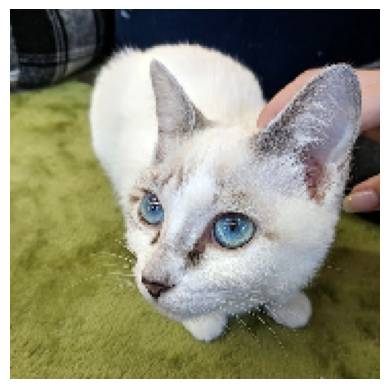

In [3]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**Instantiating a model that returns layer activations**

In [4]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    # 提取所有Conv2D和MaxPooling2D层的输出
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**Using the model to compute layer activations**

In [5]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 2s 2s/step


In [6]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


**Visualizing the fifth channel**

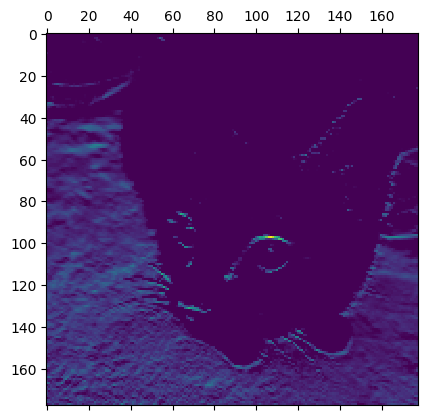

In [7]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 6], cmap="viridis")

**Visualizing every channel in every intermediate activation**

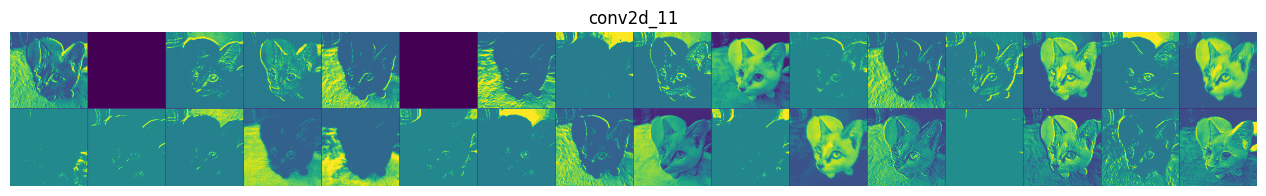

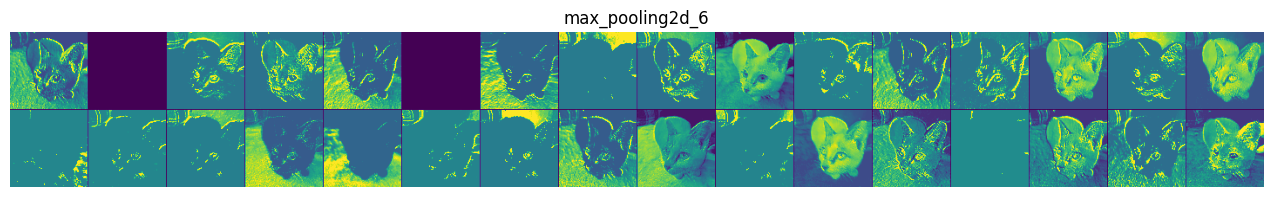

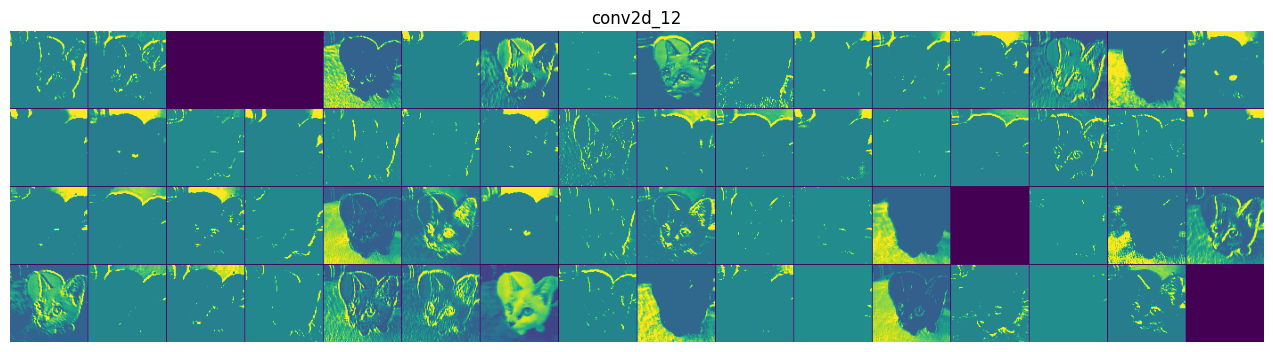

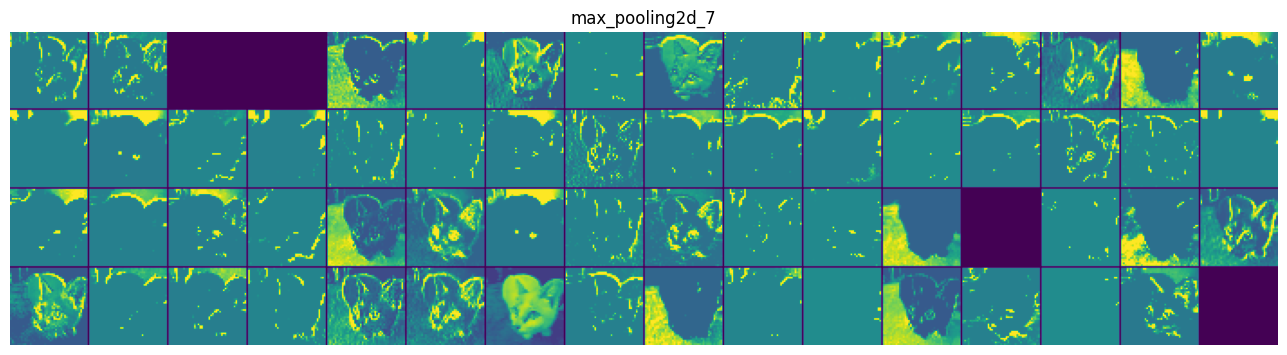

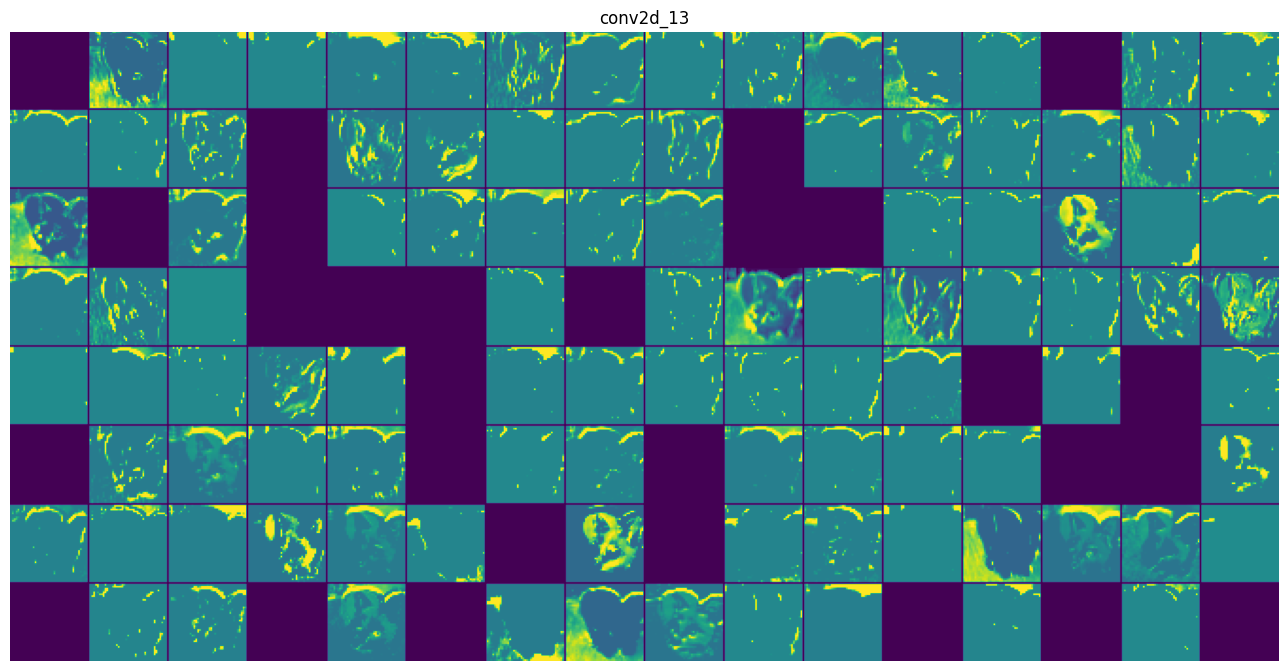

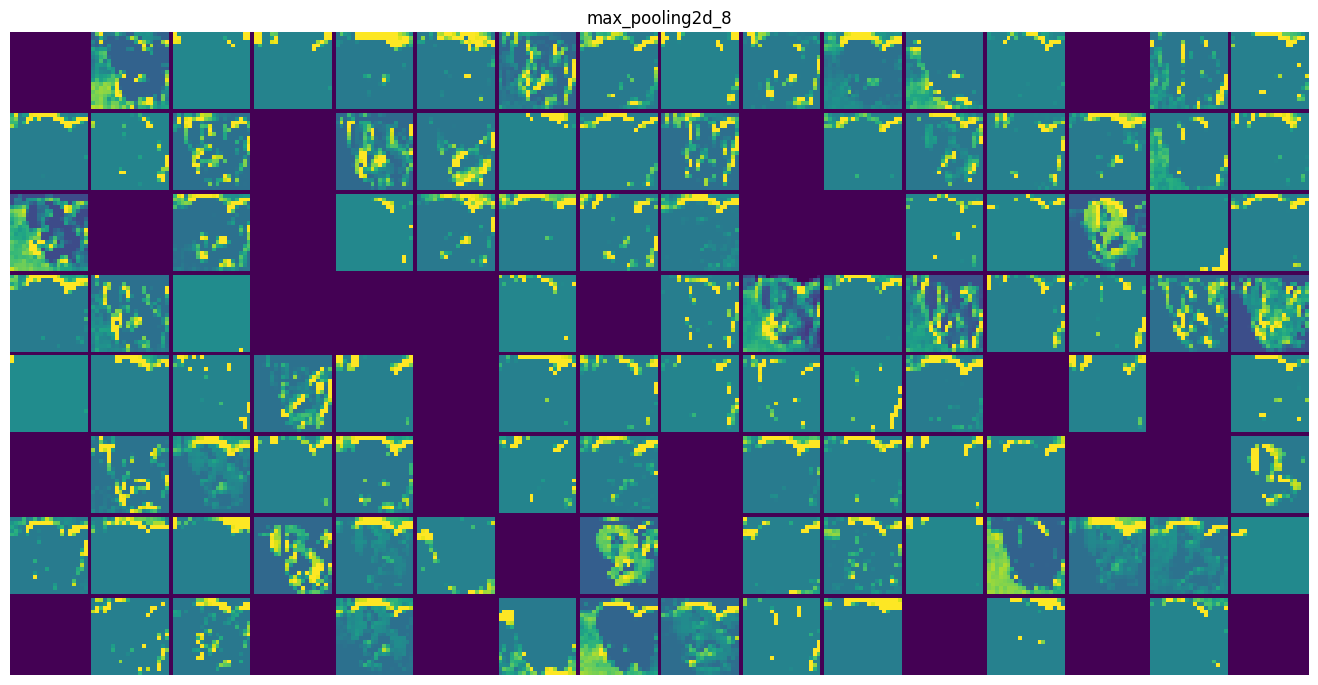

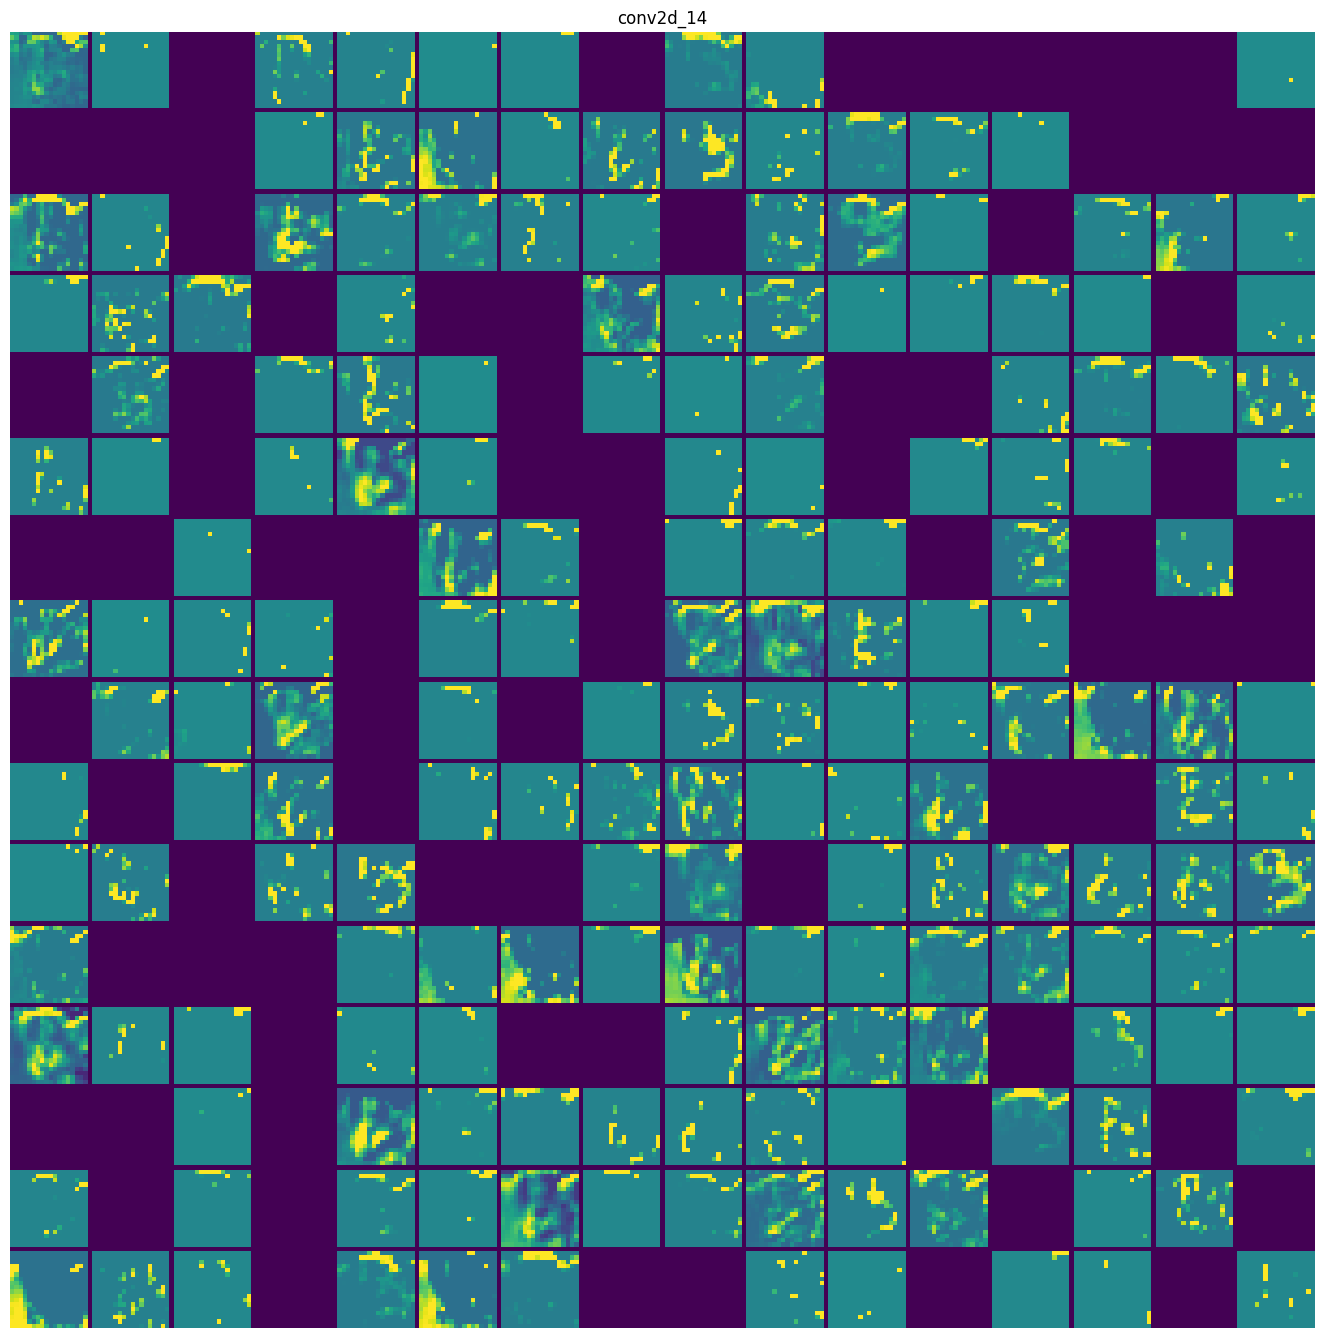

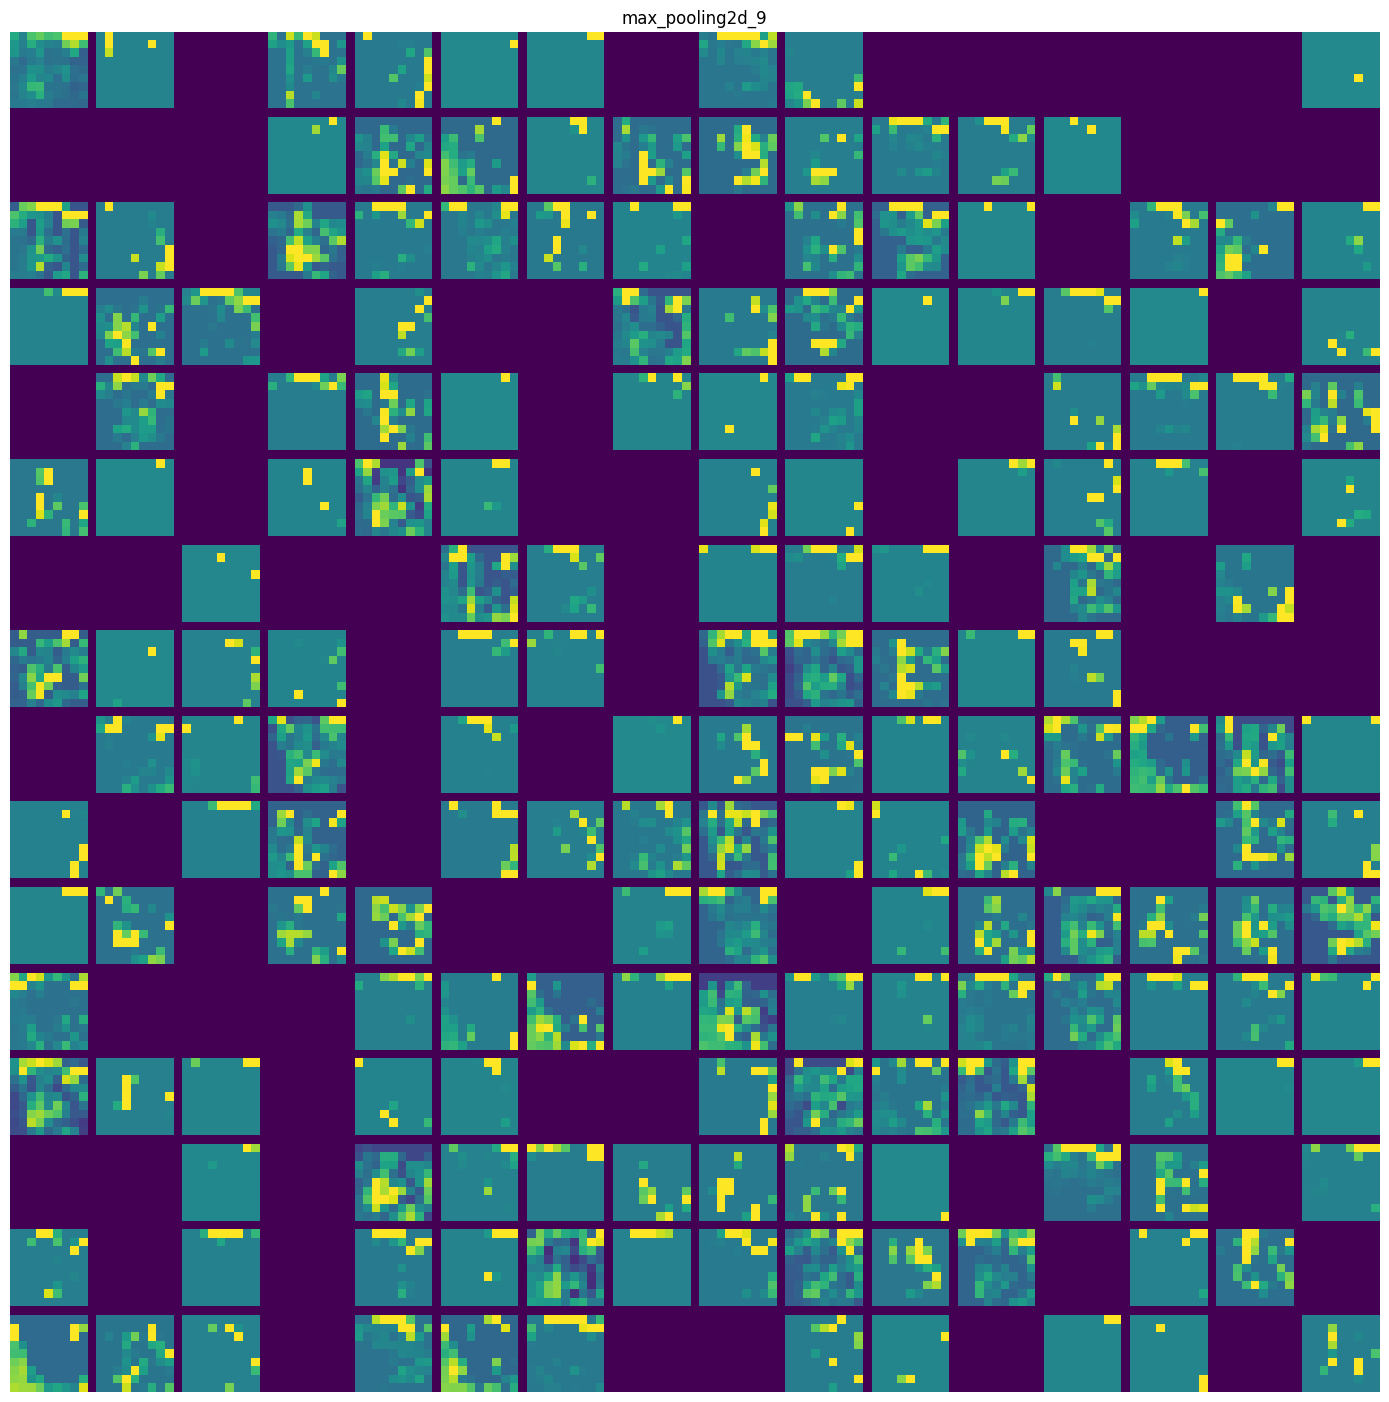

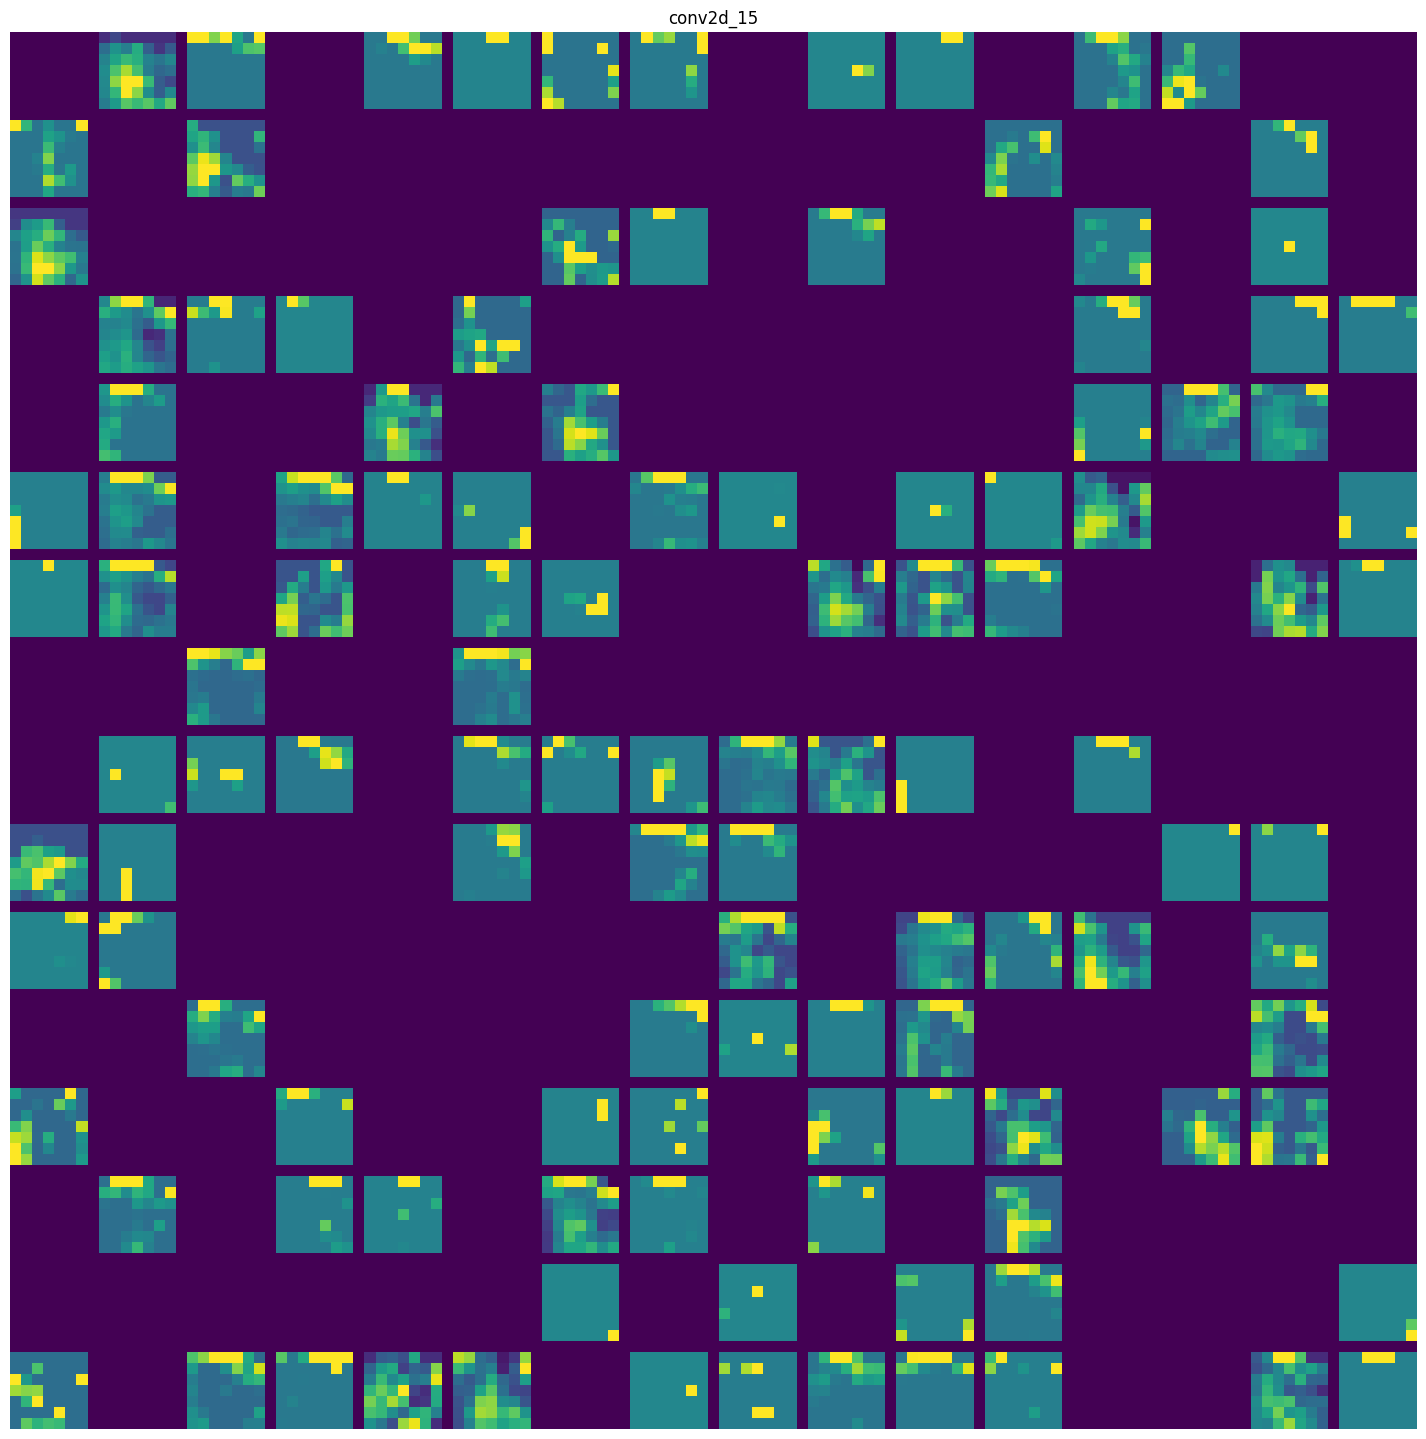

In [8]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    # 激活值的形状为(1, size, size, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    # 用于显示这个激活值中的所有通道
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            # 单个通道
            channel_image = layer_activation[0, :, :, channel_index].copy()
            # 将通道值规范化到[0,255]范围内
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            # 存入空网格
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    # 显示该层的网络        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing convnet filters

**Instantiating the Xception convolutional base**

In [9]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

**Printing the names of all convolutional layers in Xception**

In [10]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


**Creating a feature extractor model**

In [11]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

**Using the feature extractor**

In [12]:
# 用preprocess_input进行预处理
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [13]:
import tensorflow as tf

# 量化给定输入图像对该层中某个滤波器的“激活”程度
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

**Loss maximization via stochastic gradient ascent**

In [14]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    # 将梯度张量规范化，确保输入图像的更新大小始终在同一个范围内
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**Function to generate filter visualizations**

In [15]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        # 将图像张量随机初始化
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

**Utility function to convert a tensor into a valid image**

In [16]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    # 进行中心裁剪，避免边界伪影
    image = image[25:-25, 25:-25, :]
    return image

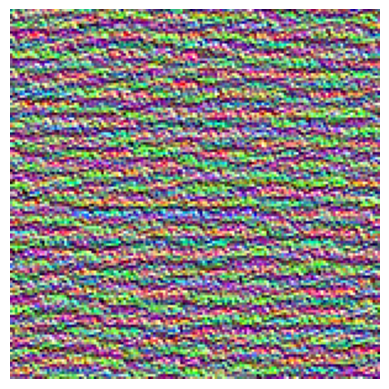

In [17]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

**Generating a grid of all filter response patterns in a layer**

In [18]:
all_images = []
# 为该层前64个滤波器生成可视化内容并保存
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# 将保存的滤波器图像填入画布
for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

# 保存文件
keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

### Visualizing heatmaps of class activation

**Loading the Xception network with pretrained weights**

In [19]:
model = keras.applications.xception.Xception(weights="imagenet")

**Preprocessing an input image for Xception**

In [20]:
# 下载本地图片
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

# 返回一张尺寸为299x299的PIL图像
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [21]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 [==============================] - 1s 550ms/step
[('n02504458', 'African_elephant', 0.8700729), ('n01871265', 'tusker', 0.07684717), ('n02504013', 'Indian_elephant', 0.0235665)]


In [22]:
np.argmax(preds[0])

386

**Setting up a model that returns the last convolutional output**

In [23]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

In [24]:
# 创建一个模型，将最后一个卷积层的激活值映射到最终的预测类别
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class**

In [25]:
# 计算输入图像的最大预测类别相对于最后一个卷积层激活值的梯度
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    # 监控该梯度
    tape.watch(last_conv_layer_output)
    # 检索与最大预测类别对应的激活通道
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**Gradient pooling and channel-importance weighting**

In [26]:
# 每个元素是某个通道的平均梯度强度，量化了每个通道对最大预测类别的重要性
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
# 将最后一个卷积层输出的每个通道乘以“该通道的重要性”
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# 所有特征图的逐个通道均值，得到类激活热力图
heatmap = np.mean(last_conv_layer_output, axis=-1)

**Heatmap post-processing**

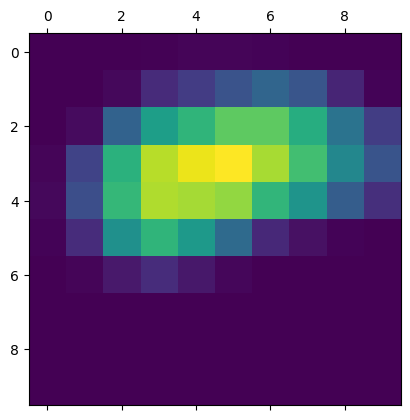

In [27]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap on the original picture**

In [28]:
import matplotlib.cm as cm

# 加载原始图像
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

# 将热力图缩放到[0,255]的范围
heatmap = np.uint8(255 * heatmap)

# 热力图着色
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# 图像叠加
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

## Summary